
# AI/ML Project 
## Manny Lazalde, Ivy Chen, Michael Vinciguera 
### November 2, 2020


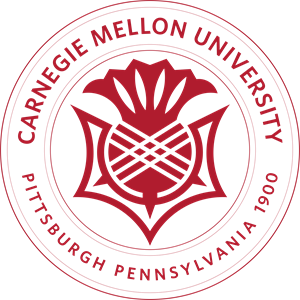

In [1]:
# All the imports 
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pylab as plt
import datetime
import cv2
import numpy as np
import io
from PIL import Image
import os
from skimage.transform import resize
from skimage import color
from skimage import io
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import layers
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
%load_ext tensorboard
from tensorboard.plugins.hparams import api as hp
from sklearn.utils import class_weight
from sklearn.metrics import plot_confusion_matrix

# Mount Drive and Load in Data



In [2]:
# Lets mount the google drive so we can use Drive as file system
from google.colab import drive
drive.mount('/content/drive')
# using ! means bash. able to use command-line like lingo
!cd 'drive/My Drive/Colab Notebooks/Car'
drive_mounted = True

Mounted at /content/drive


In [ ]:
# to unmount the drive and save any appropriate changes
if drive_mounted:
  drive.flush_and_unmount()
  print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.


# Preprocessing Data


## Format and Save Raw Images


In [ ]:
# Set the right path to the data
path_var = 'drive/My Drive/AI_ML Project/Shoulder Implants/data/'
#count the number of images in the folder
path, dirs, files = next(os.walk(path_var))
number_images = len(files)

In [ ]:
# lets try to load in our data 
images = np.ndarray(shape = (number_images, 250,250,3), dtype = np.float32)
#labels will be one hot encoded through loading
#labels = np.ndarray(shape = (number_images, 4))
labels = np.ndarray(shape = (number_images))
# lets store the names of the images as well 
image_names = []

i = 0;
# Loop through all files in folder, grabbing labels and images
for file in os.listdir(path_var):
  if file.split('.')[0] == 'Zimmer':
    #labels[i] = np.array([1,0,0,0], dtype=np.float32)
    labels[i] = 0
  elif file.split('.')[0] == 'Tornier':
    #labels[i] = np.array([0,1,0,0], dtype=np.float32)
    labels[i] = 1
  elif file.split('.')[0] == 'Depuy':
    #labels[i] = np.array([0,0,1,0], dtype=np.float32)
    labels[i] = 2
  elif file.split('.')[0] == 'Cofield':
    #labels[i] = np.array([0,0,0,1], dtype=np.float32)
    labels[i] = 3
  #read in the image
  pic = plt.imread(path_var + file,format='jpeg')
  #resize the image to the standard dimension
  pic = resize(pic,(250,250,3))
  #global standardization; subtract mean, divide by std dev
  #pic = (pic - np.mean(pic)) / np.std(pic)
  images[i] = pic
  image_names.append(file)
  i += 1



In [ ]:
#for saving the data
path_var = 'drive/My Drive/AI_ML Project/Shoulder Implants/' 
np.save(path_var + 'images_unstandardized', images)
np.save(path_var + 'labels',labels)
np.save(path_var + 'image_names',np.asarray(image_names))

## Using Keras for Preprocessing

In [ ]:
# Use images_raw, then Keras preprocessing
path_var = 'drive/My Drive/AI_ML Project/Shoulder Implants/data_split/'
#use keras to load in dataset that feeds into tf model. 
#dataset contains the labels and the images, raw
dataset = keras.preprocessing.image_dataset_from_directory(path_var,image_size = (250,250), batch_size = 64 )

Found 597 files belonging to 4 classes.


In [ ]:
plt.figure(figsize=(10, 10))
for images,labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

# Building Models


In [ ]:
#Look to this for data augmentation
# https://keras.io/examples/vision/image_classification_from_scratch/

## VGG-16

In [ ]:
# First need to grab weights from VGG16 image-net for transfer learning

#https://www.tensorflow.org/guide/keras/save_and_serialize#apis_for_saving_weights_to_disk_loading_them_back

#Use this to load in Keras VGG16 to get the pre-trained weights
pretrained = tf.keras.applications.VGG16(
    include_top=False, weights='imagenet')

#Essentially, we will be building the same model architecture, and perform 
# transfer learning with same architecture for ease of use. Then strap on 
# extra layers at the very end. 


In [ ]:
def build_VGG(pretrained):
  #Lets build the VGG 16 via the functional API
  inputs = keras.Input(shape = (250,250,3))
  # VGG16 has inputs as 224x224x3 , and scale images to be between 0 and 1

  # think about data augmentation
  # x = layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")(x)
  # x = layers.experimental.preprocessing.RandomRotation(0.2)(x)

  x = layers.Conv2D(64,(3,3),padding='same', activation = 'relu')(inputs)
  x = layers.Conv2D(64,(3,3),padding='same', activation = 'relu')(x)
  x = layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)

  x = layers.Conv2D(128, (3,3), padding = 'same', activation ='relu')(x)
  x = layers.Conv2D(128, (3,3), padding = 'same', activation ='relu')(x)
  x = layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)

  x = layers.Conv2D(256, (3,3), padding = 'same', activation ='relu')(x)
  x = layers.Conv2D(256, (3,3), padding = 'same', activation ='relu')(x)
  x = layers.Conv2D(256, (3,3), padding = 'same', activation ='relu')(x)
  x = layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)

  x = layers.Conv2D(512, (3,3), padding = 'same', activation ='relu')(x)
  x = layers.Conv2D(512, (3,3), padding = 'same', activation ='relu')(x)
  x = layers.Conv2D(512, (3,3), padding = 'same', activation ='relu')(x)
  x = layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)

  x = layers.Conv2D(512, (3,3), padding = 'same', activation ='relu')(x)
  x = layers.Conv2D(512, (3,3), padding = 'same', activation ='relu')(x)
  x = layers.Conv2D(512, (3,3), padding = 'same', activation ='relu')(x)
  x = layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)

  outputs = layers.Flatten()(x)
  model = keras.Model(inputs, outputs, name = 'VGG16')

  model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0000001),
                       loss = 'categorical_crossentropy',
                metrics=[keras.metrics.CategoricalAccuracy()
                         ])
  #use this to perform transfer learning
  model.set_weights(pretrained.get_weights())
  assert len(model.weights) == len(pretrained.weights)
  for a, b in zip(model.weights, pretrained.weights):
    np.testing.assert_allclose(a.numpy(), b.numpy())


  # Now that transfer learning is done, strap on extra FC layers 
  #add on FC layers on model to create custom VGG 16
  #x = layers.Dense(4, activation = 'softmax')(model.layers[-1].output)
  x = layers.Dense(512, activation = 'relu')(model.layers[-1].output)
  x =  layers.Dense(4,activation = 'softmax')(x)

  model = keras.Model(inputs = inputs, outputs =x, name = 'VGG16')
  # initial_learning_rate = 0.001
  # lr_schedule = keras.optimizers.schedules.ExponentialDecay(
  #     initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
  # )

  model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0000001),
                       loss = 'categorical_crossentropy',
                metrics=[keras.metrics.CategoricalAccuracy()
                         ])

  return model

### Train and Test VGG with 10-Fold Cross Validation

In [ ]:
# First get the data and split it
# Set the right path to the data
path_var = 'drive/My Drive/AI_ML Project/Shoulder Implants/'

labels = np.load(path_var + 'labels.npy')
images_raw = np.load(path_var + 'images_unstandardized.npy')
# labels = np.load(path_var + 'labels_augmented.npy')
# images_raw = np.load(path_var + 'images_augmented.npy')


images_raw = images_raw/255



# Test Train Split with raw images and one hot vectors for labels
x_train, x_test, y_train, y_test = train_test_split(images_raw, 
                                                     labels.astype(int), 
                                                    test_size=0.2,random_state=42,
                                                    stratify=labels.astype(int))
y_test  = keras.utils.to_categorical(y_test ,4)

In [ ]:
# now implement K fold cross validation
kf = StratifiedKFold(n_splits = 2)
# stores a lists of [loss, sparse_categorical_accuracy]
validation_errors = []
best_loss = 0

# With only the train data, split into validation/train
for train_index,valid_index in kf.split(x_train,y_train):
  x_train_split, x_valid_split = x_train[train_index], x_train[valid_index]
  y_train_split, y_valid_split = y_train[train_index], y_train[valid_index]
   #convert to one hot encoding
  y_train_split= keras.utils.to_categorical(y_train_split, 4)
  y_valid_split = keras.utils.to_categorical(y_valid_split,4)
  # build the model
  model = build_VGG(pretrained)
  # perform training on that model
  model.fit(x_train_split,y_train_split, batch_size = 4, epochs=25)
  # perform testing and save results to validation_errors
  results = model.evaluate(x_valid_split, y_valid_split, batch_size=4)
  pred = model.predict(x_valid_split)
  pred = np.argmax(pred,axis=-1)
  true_labels_split = np.argmax(y_valid_split,axis=-1)
  results = results[0:2] + list(precision_recall_fscore_support(true_labels_split, pred, average = 'macro')[:-1])
  results = [round(x,4) for x in results]
  validation_errors.append(results)
  # need to save the best model to then use in test
  if len(validation_errors) == 1:
    best_loss = validation_errors[0][0]
    model.save('drive/My Drive/AI_ML Project/Shoulder Implants/VGG')

  elif best_loss > validation_errors[-1][0]:
    model.save('drive/My Drive/AI_ML Project/Shoulder Implants/VGG')
    best_loss = validation_errors[-1][0]


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
model = tf.keras.models.load_model('drive/My Drive/AI_ML Project/Shoulder Implants/VGG')
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                metrics=[keras.metrics.CategoricalAccuracy()])
test_results = model.evaluate(x_test, y_test, batch_size=4)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=-1)
true_labels = np.argmax(y_test,axis=-1)
test_results = test_results[0:2] + list(precision_recall_fscore_support(true_labels, pred, average = 'macro')[:-1])
test_results = [round(x,4) for x in test_results]
print("test loss, test acc:", test_results)

### Confusion Matrix

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
model = tf.keras.models.load_model('drive/My Drive/AI_ML Project/Shoulder Implants/VGG')
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                metrics=[keras.metrics.CategoricalAccuracy()])
test_results = model.evaluate(images_raw,keras.utils.to_categorical(labels ,4), batch_size=4)
pred = model.predict(images_raw)
pred = np.argmax(pred,axis=-1)
true_labels = np.argmax(keras.utils.to_categorical(labels ,4),axis=-1)
test_results = test_results[0:2] + list(precision_recall_fscore_support(true_labels, pred, average = 'macro')[:-1])
test_results = [round(x,4) for x in test_results]

Evaluate on test data
150/150 [==============================] - 5s 34ms/step - loss: 1.2229 - categorical_accuracy: 0.4925


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix, without normalization
[[  0   0 149   0]
 [  0   0  71   0]
 [  0   0 294   0]
 [  0   0  83   0]]


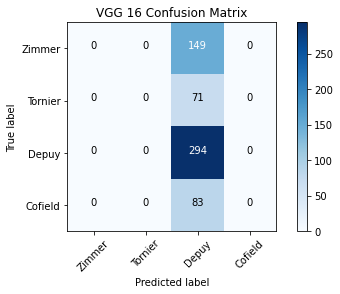

In [ ]:
cm = confusion_matrix(true_labels, pred)
import itertools
# note - this confusion matrix code was taken from https://deeplizard.com/learn/video/km7pxKy4UHU
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='VGG 16 Confusion Matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(cm,['Zimmer','Tornier','Depuy','Cofield' ])

### VGG MNIST

In [ ]:
#Use this to load in Keras VGG16 to get the pre-trained weights
VGG_16_model = tf.keras.applications.VGG16(
    include_top=False, weights='imagenet', )

In [ ]:
def build_VGG(pretrained):
  #Lets build the VGG 16 via the functional API
  inputs = keras.Input(shape = (48,48,3))

  x = layers.Conv2D(64,(3,3),padding='same', activation = 'relu')(inputs)
  x = layers.Conv2D(64,(3,3),padding='same', activation = 'relu')(x)
  x = layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)

  x = layers.Conv2D(128, (3,3), padding = 'same', activation ='relu')(x)
  x = layers.Conv2D(128, (3,3), padding = 'same', activation ='relu')(x)
  x = layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)

  x = layers.Conv2D(256, (3,3), padding = 'same', activation ='relu')(x)
  x = layers.Conv2D(256, (3,3), padding = 'same', activation ='relu')(x)
  x = layers.Conv2D(256, (3,3), padding = 'same', activation ='relu')(x)
  x = layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)

  x = layers.Conv2D(512, (3,3), padding = 'same', activation ='relu')(x)
  x = layers.Conv2D(512, (3,3), padding = 'same', activation ='relu')(x)
  x = layers.Conv2D(512, (3,3), padding = 'same', activation ='relu')(x)
  x = layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)

  x = layers.Conv2D(512, (3,3), padding = 'same', activation ='relu')(x)
  x = layers.Conv2D(512, (3,3), padding = 'same', activation ='relu')(x)
  x = layers.Conv2D(512, (3,3), padding = 'same', activation ='relu')(x)
  x = layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)

  outputs = layers.Flatten()(x)
  model = keras.Model(inputs, outputs, name = 'VGG16')

  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy')
  #use this to perform transfer learning
  model.set_weights(pretrained.get_weights())
  assert len(model.weights) == len(pretrained.weights)
  for a, b in zip(model.weights, pretrained.weights):
    np.testing.assert_allclose(a.numpy(), b.numpy())


  # Now that transfer learning is done, strap on extra FC layers 
  #add on FC layers on model to create custom VGG 16
  x = layers.Dense(512, activation = 'relu')(model.layers[-1].output)
  #x = layers.Dropout(0.5)(x)
  #x = layers.Dense(4096, activation = 'relu')(x)
  #x = layers.Dropout(0.5)(x)
  x = layers.Dense(10, activation = 'softmax')(x)

  model = keras.Model(inputs = inputs, outputs =x, name = 'VGG16')



  model.compile(optimizer = keras.optimizers.Adam(), loss = 'categorical_crossentropy',
                metrics=[keras.metrics.CategoricalAccuracy()])
  
  return model

In [ ]:
# Load in mnist data and perform pre-processing of the data
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
# perform normalization of data and stacking 
x_train = x_train.reshape(-1, 28, 28) / 255
x_train = np.stack([x_train,x_train,x_train], axis=-1)
x_test = x_test.reshape(-1, 28, 28) / 255
x_test = np.stack([x_test,x_test,x_test], axis=-1)

#convert to size 48x48 for vgg
from keras.preprocessing.image import img_to_array, array_to_img
x_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_train])
x_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_test])

#one hot vector encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
def change_shape(x):
  # Change the shape to (48, 48, 3)
  x = np.reshape(x, (len(x), 28, 28, 1))
  # Current shape (len, 28, 28, 1)
  x = tf.image.grayscale_to_rgb(tf.convert_to_tensor(x))
  # Current shape (len, 28, 28, 3)
  x = np.array(tf.image.resize(x, [48, 48]))
  # Current shape (48, 48, 3)
  # Normalise the data and change data type
  x = x / 255.
  x = x.astype('float32')
  # Preprocess input
  return x
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = change_shape(x_train)
x_test = change_shape(x_test)
#one hot vector encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [ ]:
model = build_VGG(VGG_16_model)
history = model.fit(x_train,y_train, batch_size = 256, shuffle = True,epochs=15,validation_split=0.1,
                    callbacks = tf.keras.callbacks.ReduceLROnPlateau(
                              monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              verbose=1,
                              mode='auto',
                              epsilon=0.0001,
                              cooldown=2,
                              min_lr=0))

Epoch 1/15
211/211 [==============================] - 40s 192ms/step - loss: 1.4775 - categorical_accuracy: 0.4206 - val_loss: 0.6643 - val_categorical_accuracy: 0.7513
Epoch 2/15
211/211 [==============================] - 40s 187ms/step - loss: 0.4404 - categorical_accuracy: 0.8409 - val_loss: 0.3410 - val_categorical_accuracy: 0.8790
Epoch 3/15
211/211 [==============================] - 40s 189ms/step - loss: 0.2955 - categorical_accuracy: 0.8950 - val_loss: 0.2881 - val_categorical_accuracy: 0.8990
Epoch 4/15
211/211 [==============================] - 40s 188ms/step - loss: 0.2398 - categorical_accuracy: 0.9141 - val_loss: 0.2394 - val_categorical_accuracy: 0.9165
Epoch 5/15
211/211 [==============================] - 40s 188ms/step - loss: 0.2074 - categorical_accuracy: 0.9269 - val_loss: 0.2185 - val_categorical_accuracy: 0.9257
Epoch 6/15
211/211 [==============================] - 40s 188ms/step - loss: 0.1849 - categorical_accuracy: 0.9346 - val_loss: 0.2146 - val_categorical_acc

In [ ]:
results,accuracy = model.evaluate(x_test, y_test, batch_size=256)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=-1)

40/40 [==============================] - 2s 58ms/step - loss: 0.4238 - categorical_accuracy: 0.9331


In [ ]:
list(precision_recall_fscore_support(np.argmax(y_test,axis=-1), pred, average = 'macro')[:-1])

[0.9333402441046083, 0.9330999999999999, 0.9331739006118568]

### Hyperparameter Tuning VGG




In [ ]:
# First get the data and split it
# Set the right path to the data
path_var = 'drive/My Drive/AI_ML Project/Shoulder Implants/'

labels = np.load(path_var + 'labels.npy')
images_raw = np.load(path_var + 'images_unstandardized.npy')
# labels = np.load(path_var + 'labels_augmented.npy')
# images_raw = np.load(path_var + 'images_augmented.npy')

images_raw = images_raw/255

#convert to one hot encoding
labels = keras.utils.to_categorical(labels, 4)

# Test Train Split with raw images and one hot vectors for labels
x_train, x_test, y_train, y_test = train_test_split(images_raw, 
                                                     labels.astype(int), 
                                                    test_size=0.2,random_state=42,
                                                    stratify=labels.astype(int))



In [ ]:
for i in range(4):
  print("Class "+str(i)+" Images: " +str(len(labels[labels==i])))
print()
print('TotalImages : ' + str(len(labels)))

Class 0 Images: 149
Class 1 Images: 71
Class 2 Images: 294
Class 3 Images: 83

TotalImages : 597


In [ ]:
model = build_VGG(pretrained)
#model.summary()

In [ ]:
# # for class balancing
#class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
#class_weights = dict(enumerate(class_weights))
model = build_VGG(pretrained)

# perform training on that model
model.fit(x_train,y_train, batch_size = 16, epochs=20,
                    validation_split = 0.2)#, class_weight=class_weights)#,callbacks=[reduce_lr])#, class_weight=class_weights)
# perform testing and save results to validation_errors
results = model.evaluate(x_train, y_train, batch_size=4)
pred = model.predict(x_train)
pred = np.argmax(pred,axis=-1)

Epoch 1/20
24/24 [==============================] - 7s 291ms/step - loss: 1.3630 - categorical_accuracy: 0.2415 - val_loss: 1.3507 - val_categorical_accuracy: 0.2812
Epoch 2/20
24/24 [==============================] - 7s 277ms/step - loss: 1.3472 - categorical_accuracy: 0.2415 - val_loss: 1.3385 - val_categorical_accuracy: 0.2812
Epoch 3/20
24/24 [==============================] - 7s 279ms/step - loss: 1.3324 - categorical_accuracy: 0.3255 - val_loss: 1.3268 - val_categorical_accuracy: 0.4583
Epoch 4/20
24/24 [==============================] - 7s 280ms/step - loss: 1.3181 - categorical_accuracy: 0.5013 - val_loss: 1.3151 - val_categorical_accuracy: 0.4583
Epoch 5/20
24/24 [==============================] - 7s 283ms/step - loss: 1.3043 - categorical_accuracy: 0.5013 - val_loss: 1.3059 - val_categorical_accuracy: 0.4583
Epoch 6/20
24/24 [==============================] - 7s 286ms/step - loss: 1.2926 - categorical_accuracy: 0.5013 - val_loss: 1.2964 - val_categorical_accuracy: 0.4583
Epoc

In [ ]:
 pred = model.predict(x_test)
pred = np.argmax(pred,axis=-1)
true_labels = np.argmax(y_test,axis=-1)
test_results = list(precision_recall_fscore_support(true_labels, pred, average = 'macro')[:-1])
test_results = [round(x,4) for x in test_results]
print("test loss, test acc:", test_results)
pred

test loss, test acc: [0.1229, 0.25, 0.1648]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## Resnet



In [8]:
#https://www.tensorflow.org/guide/keras/save_and_serialize#apis_for_saving_weights_to_disk_loading_them_back
# Load in the OG Resnet 50 to get the appropriate weights for transfer learning
pretrained = tf.keras.applications.ResNet50(
                  include_top=False,
                  weights="imagenet",
                  )
#ResNet_50_keras.summary()
#pretrained.summary()

In [9]:
def identity_block(x_start, filter1, filter2, filter3,group_name,block_name):
  proper_name = 'Group' + group_name + '_Block' + block_name + '_'
  x = layers.Conv2D(filter1, (1,1),padding='valid', name = proper_name + 'a')(x_start)
  x = layers.BatchNormalization(name = proper_name + 'a_BN')(x)
  x = layers.Activation('relu',name = proper_name + 'a_RELU')(x)
  x = layers.Conv2D(filter2, (3,3),padding='same', name = proper_name + 'b')(x)
  x = layers.BatchNormalization(name = proper_name + 'b_BN')(x)
  x = layers.Activation('relu',name = proper_name + 'b_RELU')(x)
  x = layers.Conv2D(filter3, (1,1),padding='valid', name = proper_name + 'c')(x)
  x = layers.BatchNormalization(name = proper_name + 'c_BN')(x)
  # simply pass starting layer to the end 
  x = layers.add([x, x_start],name = proper_name + 'add')
  x = layers.Activation('relu',name = proper_name + 'c_RELU')(x)
  return x

def projection_block(x_start, filter1, filter2, filter3,group_name,block_name,s = 2):
  proper_name = 'Group' + group_name + '_Block' + block_name + '_'
  x = layers.Conv2D(filter1, (1,1), strides=(s,s),padding='valid', name = proper_name + 'a')(x_start)
  x = layers.BatchNormalization(name = proper_name + 'a_BN')(x)
  x = layers.Activation('relu',name = proper_name + 'a_RELU')(x)
  x = layers.Conv2D(filter2, (3,3),padding='same', name = proper_name + 'b')(x)
  x = layers.BatchNormalization(name = proper_name + 'b_BN')(x)
  x = layers.Activation('relu',name = proper_name + 'b_RELU')(x)
  x = layers.Conv2D(filter3, (1,1),padding='valid', name = proper_name + 'c')(x)
  x = layers.BatchNormalization(name = proper_name + 'c_BN')(x)
  # update the x_start to reflect the change
  x_start = layers.Conv2D(filter3, (1,1), strides = (s,s), padding = 'valid',
                          name = proper_name + 'skip')(x_start)
  x_start = layers.BatchNormalization(name = proper_name + 'skip_BN')(x_start)
  x = layers.add([x_start,x],name = proper_name + 'add')
  x = layers.Activation('relu',name = proper_name + 'c_RELU')(x)
  return x


In [10]:
def build_Resnet(pretrained, image_net_weights = True):
  #Lets build the VGG 16 via the functional API
  inputs = keras.Input(shape = (250,250,3))
  # inputs as 224x224x3 , and scale images to be between 0 and 1
  #x = CenterCrop(height = 224, width = 224)(inputs)
  #x = Rescaling(scale = 1.0/255)(x)

  # image augmentation
  #x = layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(224, 224,3))(x)
  #x = layers.experimental.preprocessing.RandomRotation(0.1)(x)
  #x = layers.experimental.preprocessing.RandomZoom(0.1)(x)
                                                    

  # group 1
  x = layers.ZeroPadding2D(padding = (3,3))(inputs)
  x = layers.Conv2D(64, (7,7),strides=(2,2), 
                padding = 'valid')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.ZeroPadding2D(padding = (1,1))(x)
  x = layers.MaxPooling2D((3,3), strides=(2,2))(x)

  #group 2
  x = projection_block(x,64,64,256,'2','1',1)
  x = identity_block(x, 64,64,256,'2','2')
  x = identity_block(x, 64,64,256,'2','3')

  #group 3
  x = projection_block(x,128,128,512,'3','1')
  x = identity_block(x,128,128,512,'3','2')
  x = identity_block(x,128,128,512,'3','3')
  x = identity_block(x,128,128,512,'3','4')

  #group 4
  x = projection_block(x,256,256,1024,'4','1')
  x = identity_block(x,256,256,1024,'4','2')
  x = identity_block(x,256,256,1024,'4','3')
  x = identity_block(x,256,256,1024,'4','4')
  x = identity_block(x,256,256,1024,'4','5')
  x = identity_block(x,256,256,1024,'4','6')

  #group 5
  x = projection_block(x,512,512,2048,'5','1')
  x = identity_block(x,512,512,2048,'5','2')
  x = identity_block(x,512,512,2048,'5','3')

  outputs = layers.GlobalAveragePooling2D()(x)
  model = keras.Model(inputs, outputs, name = 'ResNet')
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy')


  #use this to perform transfer learning
  if image_net_weights:
    model.set_weights(pretrained.get_weights())
    assert len(model.weights) == len(pretrained.weights)
    for a, b in zip(model.weights, pretrained.weights):
      np.testing.assert_allclose(a.numpy(), b.numpy())

  # Now that transfer learning is done, strap on extra FC layer 
  y= layers.Dense(4, activation = 'softmax')(model.layers[-1].output)

  Resnet_model = keras.Model(inputs, y, name = 'Resnet')

  # initial_learning_rate = 0.1
  # lr_schedule = keras.optimizers.schedules.ExponentialDecay(,
  #     initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
  # )
   
  # optimizers = keras.optimizers.Adam(learning_rate=lr_schedule)
  #learning_rate=0.00001
  Resnet_model.compile(optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9),
                       loss = 'categorical_crossentropy',
                metrics=[keras.metrics.CategoricalAccuracy()
                         ])
  #model.summary()
  # before training, need to freeze layers w/ image net weights, to not change them
  # only change weights of FC at the end.
  #print(len(model.layers)) 
  # for i in range(0,178-1):
  #   model.layers[i].trainable = False

  return Resnet_model

In [11]:
# First get the data and split it
# Set the right path to the data
path_var = 'drive/My Drive/AI_ML Project/Shoulder Implants/'

labels = np.load(path_var + 'labels.npy')
images_raw = np.load(path_var + 'images_unstandardized.npy')
# labels = np.load(path_var + 'labels_augmented.npy')
# images_raw = np.load(path_var + 'images_augmented.npy')


images_raw = images_raw/255
labels = keras.utils.to_categorical(labels ,4)


# Test Train Split with raw images and one hot vectors for labels
x_train, x_test, y_train, y_test = train_test_split(images_raw, 
                                                     labels.astype(int), 
                                                    test_size=0.2,random_state=42,
                                                    stratify=labels.astype(int))

In [ ]:
model = build_Resnet(pretrained)#,False)
history = model.fit(x_train,y_train, batch_size = 4, shuffle = True,epochs=25,validation_split=0.1)

In [ ]:
train_results = model.evaluate(x_train, y_train, batch_size=4)
pred = model.predict(x_train)
pred = np.argmax(pred,axis=-1)
true_labels = np.argmax(y_train,axis=-1)
train_results = train_results[0:2] + list(precision_recall_fscore_support(true_labels, pred, average = 'macro')[:-1])
train_results = [round(x,4) for x in train_results]
train_results

120/120 [==============================] - 3s 23ms/step - loss: 0.1300 - categorical_accuracy: 0.9665


[0.13, 0.9665, 0.9541, 0.957, 0.9555]

In [ ]:
test_results = model.evaluate(x_test, y_test, batch_size=4)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=-1)
true_labels = np.argmax(y_test,axis=-1)
test_results = test_results[0:2] + list(precision_recall_fscore_support(true_labels, pred, average = 'macro')[:-1])
test_results = [round(x,4) for x in test_results]
test_results

30/30 [==============================] - 1s 24ms/step - loss: 1.6734 - categorical_accuracy: 0.6500


[1.6734, 0.65, 0.613, 0.6115, 0.6119]

### Train and Test Resnet with 10-Fold Cross Validation


In [ ]:
# First get the data and split it
# Set the right path to the data
path_var = 'drive/My Drive/AI_ML Project/Shoulder Implants/'

labels = np.load(path_var + 'labels.npy')
images_raw = np.load(path_var + 'images_unstandardized.npy')
# labels = np.load(path_var + 'labels_augmented.npy')
# images_raw = np.load(path_var + 'images_augmented.npy')


images_raw = images_raw/255



# Test Train Split with raw images and one hot vectors for labels
x_train, x_test, y_train, y_test = train_test_split(images_raw, 
                                                     labels.astype(int), 
                                                    test_size=0.2,random_state=42,
                                                    stratify=labels.astype(int))
y_test  = keras.utils.to_categorical(y_test ,4)

In [ ]:
# now implement K fold cross validation
kf = StratifiedKFold(n_splits = 10)
# stores a lists of [loss, sparse_categorical_accuracy]
validation_errors = []
best_loss = 0

# With only the train data, split into validation/train
for train_index,valid_index in kf.split(x_train,y_train):
  x_train_split, x_valid_split = x_train[train_index], x_train[valid_index]
  y_train_split, y_valid_split = y_train[train_index], y_train[valid_index]
  #convert to one hot encoding
  y_train_split= keras.utils.to_categorical(y_train_split, 4)
  y_valid_split = keras.utils.to_categorical(y_valid_split,4)
  # build the model
  model = build_Resnet(pretrained,False)
  # perform training on that model
  model.fit(x_train_split,y_train_split, batch_size = 4, epochs=25)
  # perform testing and save results to validation_errors
  results = model.evaluate(x_valid_split, y_valid_split, batch_size=4)
  pred = model.predict(x_valid_split)
  pred = np.argmax(pred,axis=-1)
  true_labels_split = np.argmax(y_valid_split,axis=-1)
  results = results[0:2] + list(precision_recall_fscore_support(true_labels_split, pred, average = 'macro')[:-1])
  results = [round(x,4) for x in results]
  validation_errors.append(results)
  # need to save the best model to then use in test
  if len(validation_errors) == 1:
    best_loss = validation_errors[0][0]
    model.save('drive/My Drive/AI_ML Project/Shoulder Implants/Resnet')
  elif best_loss > validation_errors[-1][0]:
    model.save('drive/My Drive/AI_ML Project/Shoulder Implants/Resnet')
    best_loss = validation_errors[-1][0]
print(best_loss)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
model = tf.keras.models.load_model('drive/My Drive/AI_ML Project/Shoulder Implants/Resnet')
model.compile(optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9),
                       loss = 'categorical_crossentropy',
                metrics=[keras.metrics.CategoricalAccuracy()
                         ])
test_results = model.evaluate(x_test, y_test, batch_size=4)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=-1)
true_labels = np.argmax(y_test,axis=-1)
test_results = test_results[0:2] + list(precision_recall_fscore_support(true_labels, pred, average = 'macro')[:-1])
test_results = [round(x,4) for x in test_results]
print("test loss, test acc:", test_results)

In [ ]:
print(test_results)
validation_errors

In [ ]:
np.mean(np.asarray(validation_errors),axis = 0)

### Confusion Matrix

In [12]:
labels = np.load(path_var + 'labels.npy')
images_raw = np.load(path_var + 'images_unstandardized.npy')
# labels = np.load(path_var + 'labels_augmented.npy')
# images_raw = np.load(path_var + 'images_augmented.npy')


images_raw = images_raw/255
#labels = keras.utils.to_categorical(labels ,4)

In [13]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
model = tf.keras.models.load_model('drive/My Drive/AI_ML Project/Shoulder Implants/Resnet_Augmented')
model.compile(optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9),
                       loss = 'categorical_crossentropy',
                               metrics=[keras.metrics.CategoricalAccuracy()
                         ])
test_results = model.evaluate(images_raw,keras.utils.to_categorical(labels ,4), batch_size=4)
pred = model.predict(images_raw)
pred = np.argmax(pred,axis=-1)
true_labels = np.argmax(keras.utils.to_categorical(labels ,4),axis=-1)
test_results = test_results[0:2] + list(precision_recall_fscore_support(true_labels, pred, average = 'macro')[:-1])
test_results = [round(x,4) for x in test_results]
print("test loss, test acc:", test_results)

Evaluate on test data
150/150 [==============================] - 3s 21ms/step - loss: 0.0412 - categorical_accuracy: 0.9916
test loss, test acc: [0.0412, 0.9916, 0.9919, 0.9957, 0.9937]


Confusion matrix, without normalization
[[149   0   0   0]
 [  0  71   0   0]
 [  5   0 289   0]
 [  0   0   0  83]]


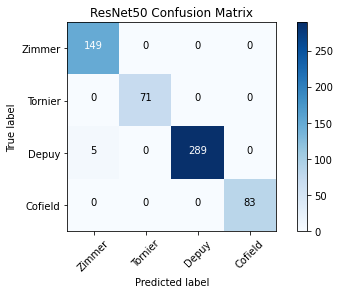

In [ ]:
cm = confusion_matrix(true_labels, pred)
import itertools
# note - this confusion matrix code was taken from https://deeplizard.com/learn/video/km7pxKy4UHU
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='ResNet50 Confusion Matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(cm,['Zimmer','Tornier','Depuy','Cofield' ])

### Resnet MNIST

In [ ]:
#https://www.tensorflow.org/guide/keras/save_and_serialize#apis_for_saving_weights_to_disk_loading_them_back
# Load in the OG Resnet 50 to get the appropriate weights for transfer learning
ResNet_50_keras = tf.keras.applications.ResNet50(
                  #include_top=True,
                  include_top=False,
                  weights="imagenet",
                  )

#ResNet_50_keras.summary()
#pretrained.summary()

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
def build_Resnet(pretrained):
  #Lets build the VGG 16 via the functional API
  inputs = keras.Input(shape=(28,28,3))
  # image augmentation                                                   

  # group 1
  x = layers.ZeroPadding2D(padding = (3,3))(inputs)
  x = layers.Conv2D(64, (7,7),strides=(2,2), 
                padding = 'valid')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.ZeroPadding2D(padding = (1,1))(x)
  x = layers.MaxPooling2D((3,3), strides=(2,2))(x)

  #group 2
  x = projection_block(x,64,64,256,'2','1',1)
  x = identity_block(x, 64,64,256,'2','2')
  x = identity_block(x, 64,64,256,'2','3')

  #group 3
  x = projection_block(x,128,128,512,'3','1')
  x = identity_block(x,128,128,512,'3','2')
  x = identity_block(x,128,128,512,'3','3')
  x = identity_block(x,128,128,512,'3','4')

  #group 4
  x = projection_block(x,256,256,1024,'4','1')
  x = identity_block(x,256,256,1024,'4','2')
  x = identity_block(x,256,256,1024,'4','3')
  x = identity_block(x,256,256,1024,'4','4')
  x = identity_block(x,256,256,1024,'4','5')
  x = identity_block(x,256,256,1024,'4','6')

  #group 5
  x = projection_block(x,512,512,2048,'5','1')
  x = identity_block(x,512,512,2048,'5','2')
  x = identity_block(x,512,512,2048,'5','3')

  outputs = layers.GlobalAveragePooling2D()(x)
  model = keras.Model(inputs, outputs, name = 'ResNet')
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy')


  #use this to perform transfer learning
  model.set_weights(pretrained.get_weights())
  assert len(model.weights) == len(pretrained.weights)
  for a, b in zip(model.weights, pretrained.weights):
    np.testing.assert_allclose(a.numpy(), b.numpy())

  # Now that transfer learning is done, strap on extra FC layer 

  x = layers.Dense(10, activation = 'softmax')(model.layers[-1].output)

  model = keras.Model(inputs = inputs, outputs =x, name = 'Resnet')

  model.compile(optimizer = keras.optimizers.Adam(learning_rate=.01), loss = 'categorical_crossentropy',
                metrics=[keras.metrics.CategoricalAccuracy()
                         ])
  return model

In [ ]:
# Load in mnist data and perform pre-processing of the data
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
# perform normalization of data and stacking 
x_train = x_train.reshape(-1, 28, 28) / 255
x_train = np.stack([x_train,x_train,x_train], axis=-1)
x_test = x_test.reshape(-1, 28, 28) / 255
x_test = np.stack([x_test,x_test,x_test], axis=-1)
#one hot vector encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [ ]:
model = build_Resnet(ResNet_50_keras)
history = model.fit(x_train,y_train, batch_size = 128, shuffle = True,epochs=15,validation_split=0.1)

Epoch 1/15
422/422 [==============================] - 30s 72ms/step - loss: 1.3877 - categorical_accuracy: 0.5530 - val_loss: 2.8121 - val_categorical_accuracy: 0.2827
Epoch 2/15
422/422 [==============================] - 28s 66ms/step - loss: 0.8276 - categorical_accuracy: 0.7534 - val_loss: 1042169024.0000 - val_categorical_accuracy: 0.0973
Epoch 3/15
422/422 [==============================] - 28s 66ms/step - loss: 0.6916 - categorical_accuracy: 0.7368 - val_loss: 0.6162 - val_categorical_accuracy: 0.7520
Epoch 4/15
422/422 [==============================] - 28s 67ms/step - loss: 0.5178 - categorical_accuracy: 0.8081 - val_loss: 0.5890 - val_categorical_accuracy: 0.7897
Epoch 5/15
422/422 [==============================] - 28s 67ms/step - loss: 0.4392 - categorical_accuracy: 0.8355 - val_loss: 0.4872 - val_categorical_accuracy: 0.8140
Epoch 6/15
422/422 [==============================] - 28s 66ms/step - loss: 0.3912 - categorical_accuracy: 0.8562 - val_loss: 0.5084 - val_categorical_

In [ ]:
results,accuracy = model.evaluate(x_test, y_test, batch_size=128)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=-1)

79/79 [==============================] - 1s 18ms/step - loss: 0.3426 - categorical_accuracy: 0.8718


In [ ]:
list(precision_recall_fscore_support(np.argmax(y_test,axis=-1), pred, average = 'macro')[:-1])

[0.8779267399240483, 0.8718, 0.8720276347206933]

### Hyperparameter Tuning Resnet





In [ ]:
def build_train_Resnet(pretrained,hparams,logdir):
  #Lets build the VGG 16 via the functional API
  inputs = keras.Input(shape = (250,250,3))
  # inputs as 224x224x3 , and scale images to be between 0 and 1
  x = CenterCrop(height = 224, width = 224)(inputs)
  x = Rescaling(scale = 1.0/255)(x)
  #image_augmentation
  x = layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(224, 224,3))(x)
  x = layers.experimental.preprocessing.RandomRotation(0.1)(x)
  x = layers.experimental.preprocessing.RandomZoom(0.1)(x)
  # group 1
  x = layers.ZeroPadding2D(padding = (3,3))(x)
  x = layers.Conv2D(64, (7,7),strides=(2,2), 
                padding = 'valid')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.ZeroPadding2D(padding = (1,1))(x)
  x = layers.MaxPooling2D((3,3), strides=(2,2))(x)

  #group 2
  x = projection_block(x,64,64,256,'2','1',1)
  x = identity_block(x, 64,64,256,'2','2')
  x = identity_block(x, 64,64,256,'2','3')

  #group 3
  x = projection_block(x,128,128,512,'3','1')
  x = identity_block(x,128,128,512,'3','2')
  x = identity_block(x,128,128,512,'3','3')
  x = identity_block(x,128,128,512,'3','4')

  #group 4
  x = projection_block(x,256,256,1024,'4','1')
  x = identity_block(x,256,256,1024,'4','2')
  x = identity_block(x,256,256,1024,'4','3')
  x = identity_block(x,256,256,1024,'4','4')
  x = identity_block(x,256,256,1024,'4','5')
  x = identity_block(x,256,256,1024,'4','6')

  #group 5
  x = projection_block(x,512,512,2048,'5','1')
  x = identity_block(x,512,512,2048,'5','2')
  x = identity_block(x,512,512,2048,'5','3')

  outputs = layers.GlobalAveragePooling2D()(x)
  model= keras.Model(inputs, outputs, name = 'ResNet')


  #use this to perform transfer learning
  model.set_weights(pretrained.get_weights())
  assert len(model.weights) == len(pretrained.weights)
  for a, b in zip(model.weights, pretrained.weights):
    np.testing.assert_allclose(a.numpy(), b.numpy())

  # Now that transfer learning is done, strap on extra FC layer 
  x = layers.Dense(4, activation = 'softmax')(model.layers[-1].output)

  resnet_model = keras.Model(inputs = inputs, outputs =x, name = 'Resnet')
  optimizer_name = hparams[HP_OPTIMIZER]
  learning_rate = hparams[HP_Learning_Rate]
  if optimizer_name == "adam":
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  elif optimizer_name == "sgd":
      optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  resnet_model.compile(optimizer=optimizer, loss = 'sparse_categorical_crossentropy',
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

  # before training, need to freeze layers w/ image net weights, to not change them
  # only change weights of FC at the end.
  for layer in model.layers:
    layer.trainable = False


  resnet_model.fit(x_train,y_train, batch_size = hparams[HP_Batch_Size], shuffle = False,epochs=25,
                    validation_split=0.2, callbacks=[
        tf.keras.callbacks.TensorBoard(logdir),  # log metrics
        hp.KerasCallback(logdir, hparams),  # log hparams
    ],)
  
  results,accuracy = resnet_model.evaluate(x_train, y_train, batch_size=64)

  return accuracy


In [ ]:
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
HP_Learning_Rate= hp.HParam('learning_rate', hp.RealInterval(0.00001,0.002))
HP_Batch_Size= hp.HParam('batch_size', hp.Discrete([8,16,32]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('drive/My Drive/AI_ML Project/Shoulder Implants/logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_OPTIMIZER,HP_Learning_Rate,HP_Batch_Size],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )


In [ ]:
session_num = 0

for learning_rate in (HP_Learning_Rate.domain.min_value, HP_Learning_Rate.domain.max_value):
  for batch_size in HP_Batch_Size.domain.values:
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_Learning_Rate: learning_rate,
          HP_OPTIMIZER: optimizer,
          HP_Batch_Size: batch_size
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      build_train_Resnet(pretrained, hparams,'drive/My Drive/AI_ML Project/Shoulder Implants/logs/hparam_tuning/'+ run_name)
      session_num += 1

--- Starting trial: run-0
{'learning_rate': 1e-05, 'optimizer': 'adam', 'batch_size': 8}
Epoch 1/25
 1/48 [..............................] - ETA: 0s - loss: 1.6836 - sparse_categorical_accuracy: 0.1250WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
48/48 [==============================] - 7s 149ms/step - loss: 1.5022 - sparse_categorical_accuracy: 0.2572 - val_loss: 1.3118 - val_sparse_categorical_accuracy: 0.4792
Epoch 2/25
48/48 [==============================] - 6s 116ms/step - loss: 1.1665 - sparse_categorical_accuracy: 0.4908 - val_loss: 1.5135 - val_sparse_categorical_accuracy: 0.1771
Epoch 3/25
48/48 [==============================] - 6s 116ms/step - loss: 1.0542 - sparse_categorical_accuracy: 0.5486 - val_loss: 1.5596 - val_sparse_categorical_accuracy:

In [ ]:
%tensorboard --logdir 'drive/My Drive/AI_ML Project/Shoulder Implants/logs/hparam_tuning/'


### Pytorch Resnet - For Sanity Check


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
data_transforms = {
    'data_split': transforms.Compose([
        transforms.CenterCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = 'drive/My Drive/AI_ML Project/Shoulder Implants'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['data_split']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['data_split']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['data_split']}
class_names = image_datasets['data_split'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


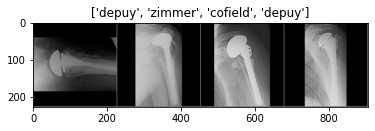

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['data_split']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['data_split']:
            if phase == 'data_split':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'data_split'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'data_split':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'data_split':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    #print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
data_split Loss: 1.3942 Acc: 0.4405

Epoch 1/24
----------
data_split Loss: 1.3025 Acc: 0.4958

Epoch 2/24
----------
data_split Loss: 1.1325 Acc: 0.5494

Epoch 3/24
----------
data_split Loss: 1.0618 Acc: 0.5997

Epoch 4/24
----------
data_split Loss: 0.9290 Acc: 0.6566

Epoch 5/24
----------
data_split Loss: 0.5929 Acc: 0.7755

Epoch 6/24
----------
data_split Loss: 0.8355 Acc: 0.7102

Epoch 7/24
----------
data_split Loss: 0.4262 Acc: 0.8459

Epoch 8/24
----------
data_split Loss: 0.3075 Acc: 0.8961

Epoch 9/24
----------
data_split Loss: 0.2821 Acc: 0.9129

Epoch 10/24
----------
data_split Loss: 0.2746 Acc: 0.9162

Epoch 11/24
----------
data_split Loss: 0.2384 Acc: 0.9263

Epoch 12/24
----------
data_split Loss: 0.1796 Acc: 0.9598

Epoch 13/24
----------
data_split Loss: 0.2112 Acc: 0.9313

Epoch 14/24
----------
data_split Loss: 0.1581 Acc: 0.9581

Epoch 15/24
----------
data_split Loss: 0.1707 Acc: 0.9581

Epoch 16/24
----------
data_split Loss: 0.1692 Acc

In [ ]:
#model_ft.train()
labels_list = []
pred_list = []

for inputs, labels in dataloaders['data_split']:
  inputs = inputs.to(device)
  labels = labels.to(device)
  outputs = model_ft(inputs)
  _, preds = torch.max(outputs, 1)
  labels_list.append(torch.Tensor.cpu(labels).detach().numpy()[:,])
  pred_list.append(torch.Tensor.cpu(preds).detach().numpy()[:,])

In [ ]:
labels_list = np.vstack( labels_list[:-1]).reshape(-1)
pred_list= np.vstack( pred_list[:-1]).reshape(-1)

In [ ]:
precision_recall_fscore_support(labels_list, pred_list, average = 'micro')

(0.2197986577181208, 0.2197986577181208, 0.21979865771812077, None)